In [1]:
import time
import collections
import pickle
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.cluster import KMeans
from sliding_window import sliding_window
from cluster_eval import greedy_relabel
from cluster_eval import brute_relabel
from cluster_eval import print_results
from cluster_eval import relabel_list
from keras import layers

# Hardcoded length of the sliding window mechanism employed to segment the data
SLIDING_WINDOW_LENGTH = 24

# Hardcoded step of the sliding window mechanism employed to segment the data
SLIDING_WINDOW_STEP = 12

In [2]:
def load_dataset(filename):

    f = open(filename, 'rb')
    data = pickle.load(f)
    f.close()

    X_train, y_train = data[0]
    X_test, y_test = data[1]

    print(" ..from file {}".format(filename))
    print(" ..reading instances: train {0}, test {1}".format(X_train.shape, X_test.shape))

    X_train = X_train.astype(np.float32)
    X_test = X_test.astype(np.float32)

    # The targets are casted to int8 for GPU compatibility.
    y_train = y_train.astype(np.uint8)
    y_test = y_test.astype(np.uint8)

    return X_train, y_train, X_test, y_test

print("Loading data...")
X_train, y_train, X_test, y_test = load_dataset('oppChallenge_locomotion.data')

def remove_class(X_train, y_train, X_test, y_test, class_n):
    uy_train = y_train[y_train != class_n]
    uX_train = X_train[y_train != class_n]
    uy_test = y_test[y_test != class_n]
    uX_test = X_test[y_test != class_n]
    
    classes = set(y_train)
    
    for x in range(class_n + 1, len(classes)):
        uy_train[uy_train == x] = x - 1
        uy_test[uy_test == x] = x - 1
        
    return uX_train, uy_train, uX_test, uy_test

# def delete_features():
# RKN^, RKN_, BACK, HIP, R-SHOE, L-SHOE
# 53 Features

#features_delete = np.arange(6, 15)
#features_delete = np.concatenate([features_delete, np.arange(21, 36)])
#features_delete = np.concatenate([features_delete, np.arange(45, 81)])

# 60 Features
#features_delete = np.arange(0, 6)
#features_delete = np.concatenate([features_delete, np.arange(15, 21)])
#features_delete = np.concatenate([features_delete, np.arange(36, 45)])
#features_delete = np.concatenate([features_delete, np.arange(81, 113)])

# 9 Features (Phone)
#features_delete = np.arange(0, 36)
#features_delete = np.concatenate([features_delete, np.arange(45, 113)])

#features_delete = np.concatenate([features_delete, np.arange(6, 113)])

#X_train = np.delete(X_train, features_delete, 1)
#X_test = np.delete(X_test, features_delete, 1)

classes = ["Null", "Stand", "Walk" ,"Sit", "Lie"]

# 0 - null | 1 - stand | 2 - walk | 3 - sit | 4 - lie

X_train, y_train, X_test, y_test = remove_class(X_train, y_train, X_test, y_test, 0) # remove null
classes.remove("Null")

# 0 - stand | 1 - walk | 2 - sit | 3 - lie

#X_train, y_train, X_test, y_test = remove_class(X_train, y_train, X_test, y_test, 1) # remove walking
#classes.remove("Walk")

#X_train, y_train, X_test, y_test = remove_class(X_train, y_train, X_test, y_test, 3) # remove walking
#classes.remove("Lie")

#X_train, y_train, X_test, y_test = remove_class(X_train, y_train, X_test, y_test, 2) # remove walking
#classes.remove("Sit")

# 0 - stand | 1 - sit | 2 - lie

print(X_train.shape)
print(X_test.shape)

unique, counts = np.unique(y_train, return_counts=True)
label_dict = dict(zip(unique, counts))
print(label_dict)

Loading data...
 ..from file oppChallenge_locomotion.data
 ..reading instances: train (557963, 113), test (118750, 113)
(465668, 113)
(94260, 113)
{0: 231751, 1: 130506, 2: 88883, 3: 14528}


In [3]:
def opp_sliding_window(data_x, data_y, ws, ss):
    data_x = sliding_window(data_x,(ws,data_x.shape[1]),(ss,1))
    data_y = np.asarray([[i[-1]] for i in sliding_window(data_y,ws,ss)])
    return data_x.astype(np.float32), data_y.reshape(len(data_y)).astype(np.uint8)

# Sensor data is segmented using a sliding window mechanism

X_train, y_train = opp_sliding_window(X_train, y_train, SLIDING_WINDOW_LENGTH, SLIDING_WINDOW_STEP)
X_test, y_test = opp_sliding_window(X_test, y_test, SLIDING_WINDOW_LENGTH, SLIDING_WINDOW_STEP)

print(" ..after sliding window (testing): inputs {0}, targets {1}".format(X_test.shape, y_test.shape))

print(X_train.shape)
print(X_test.shape)

 ..after sliding window (testing): inputs (7854, 24, 113), targets (7854,)
(38804, 24, 113)
(7854, 24, 113)


In [4]:
import operator
import tensorflow as tf
from numpy.random import seed
from keras.models import Sequential
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from keras.callbacks import TensorBoard
from sklearn.cluster import KMeans

In [14]:
# lstm autoencoder doesnt need a sliding window, redudent data can lead to overfitting

n = 5
seed(n)
tf.random.set_seed(n)

model = Sequential()
# encoder
model.add(LSTM(64, activation="relu", input_shape=(SLIDING_WINDOW_LENGTH, 113), return_sequences=True))
model.add(LSTM(32, activation="relu", return_sequences=False))
#model.add(LSTM(16, activation="relu", return_sequences=False))
model.add(RepeatVector(SLIDING_WINDOW_LENGTH))
# decoder
#model.add(LSTM(16, activation="relu", return_sequences=True))
model.add(LSTM(32, activation="relu", return_sequences=True))
model.add(LSTM(64, activation="relu", return_sequences=True))
model.add(TimeDistributed(Dense(113)))
model.compile(optimizer="adam", loss="mse")
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 24, 64)            45568     
_________________________________________________________________
lstm_21 (LSTM)               (None, 32)                12416     
_________________________________________________________________
repeat_vector_10 (RepeatVect (None, 24, 32)            0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 24, 32)            8320      
_________________________________________________________________
lstm_23 (LSTM)               (None, 24, 64)            24832     
_________________________________________________________________
time_distributed_10 (TimeDis (None, 24, 113)           7345      
Total params: 98,481
Trainable params: 98,481
Non-trainable params: 0
_________________________________________________

In [15]:
model.fit(X_train, X_train, epochs=15, batch_size=100, validation_split=0.1)

Epoch 1/15
350/350 [==============================] - 16s 35ms/step - loss: 0.0682 - val_loss: 0.0056
Epoch 2/15
350/350 [==============================] - 12s 34ms/step - loss: 0.0045 - val_loss: 0.0048
Epoch 3/15
350/350 [==============================] - 12s 34ms/step - loss: 0.0039 - val_loss: 0.0045
Epoch 4/15
350/350 [==============================] - 11s 33ms/step - loss: 0.0035 - val_loss: 0.0039
Epoch 5/15
350/350 [==============================] - 11s 33ms/step - loss: 0.0032 - val_loss: 0.0036
Epoch 6/15
350/350 [==============================] - 12s 33ms/step - loss: 0.0030 - val_loss: 0.0035
Epoch 7/15
350/350 [==============================] - 11s 32ms/step - loss: 0.0028 - val_loss: 0.0032
Epoch 8/15
350/350 [==============================] - 11s 32ms/step - loss: 0.0026 - val_loss: 0.0031
Epoch 9/15
350/350 [==============================] - 11s 33ms/step - loss: 0.0025 - val_loss: 0.0030
Epoch 10/15
350/350 [==============================] - 11s 32ms/step - loss: 0.002

In [ ]:
model.save('rae24_12_s0_d2')

In [14]:
# load model
model = keras.models.load_model('rae24_12_s0_d2')

In [16]:
# encoder becomes output
encoder = keras.Model(inputs=model.inputs, outputs=model.layers[1].output)

In [17]:
# get encoded data
encoded_train = encoder.predict(X_train, verbose=0)
encoded_test = encoder.predict(X_test, verbose=0)
print(encoded_train.shape)
print(encoded_test.shape)

(38804, 32)
(7854, 32)


In [18]:
NUMBER_OF_CLUSTERS = 11

start = time.time()

y_pred = KMeans(n_clusters=NUMBER_OF_CLUSTERS, random_state=0).fit(encoded_train).predict(encoded_test)

end = time.time()

print("Time:")
print(end - start)

Time:
1.8648900985717773


In [12]:
print(len(set(y_pred)))

10


In [19]:
uy_pred = y_pred.copy()
clusters = list(set(y_pred))
clusters.sort()

#relabels = brute_relabel(uy_pred, y_test)
relabels = greedy_relabel(uy_pred, y_test)
#relabels = [3, 0, 0, 1, 0, 0, 0, 0, 0, 3, 2]

uy_pred = relabel_list(uy_pred, clusters, relabels)
print_results(uy_pred, y_test, relabels)

Assigned Labels:
[3, 0, 0, 2, 0, 1, 0, 3, 1, 0, 2]

F1:
0.7497008355372223

Accuracy:
0.7450980392156863

ARI:
0.4592622583888238


In [5]:
for n in range(0,10):
    seed(n)
    tf.random.set_seed(n)

    model = Sequential()
    # encoder
    model.add(LSTM(64, activation='relu', input_shape=(SLIDING_WINDOW_LENGTH, 113), return_sequences=True))
    model.add(LSTM(32, activation='relu', return_sequences=False))
    #model.add(LSTM(16, activation='relu', return_sequences=False))
    model.add(RepeatVector(SLIDING_WINDOW_LENGTH))
    # decoder
    #model.add(LSTM(16, activation='relu', return_sequences=True))
    model.add(LSTM(32, activation='relu', return_sequences=True))
    model.add(LSTM(64, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(113)))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, X_train, epochs=5, batch_size=100, validation_split=0.15)
    
    encoder = keras.Model(inputs=model.inputs, outputs=model.layers[1].output)
    encoded_train = encoder.predict(X_train, verbose=0)
    encoded_test = encoder.predict(X_test, verbose=0)
    
    NUMBER_OF_CLUSTERS = 11

    start = time.time()
    y_pred = KMeans(n_clusters=NUMBER_OF_CLUSTERS, random_state=0).fit(encoded_train).predict(encoded_test)
    end = time.time()

    print("Time:")
    print(end - start)
    print()
    
    uy_pred = y_pred.copy()
    clusters = list(set(y_pred))
    clusters.sort()
    
    relabels = greedy_relabel(uy_pred, y_test)

    uy_pred = relabel_list(uy_pred, clusters, relabels)
    print_results(uy_pred, y_test, relabels)

Epoch 1/15
330/330 [==============================] - 14s 31ms/step - loss: 0.0818 - val_loss: 0.0057
Epoch 2/15
330/330 [==============================] - 9s 26ms/step - loss: 0.0051 - val_loss: 0.0049
Epoch 3/15
330/330 [==============================] - 9s 26ms/step - loss: 0.0044 - val_loss: 0.0047
Epoch 4/15
330/330 [==============================] - 9s 26ms/step - loss: 0.0041 - val_loss: 0.0046
Epoch 5/15
330/330 [==============================] - 8s 26ms/step - loss: 0.0039 - val_loss: 0.0045
Epoch 6/15
330/330 [==============================] - 8s 26ms/step - loss: 0.0037 - val_loss: 0.0044
Epoch 7/15
330/330 [==============================] - 9s 26ms/step - loss: 0.0035 - val_loss: 0.0043
Epoch 8/15
330/330 [==============================] - 9s 26ms/step - loss: 0.0034 - val_loss: 0.0042
Epoch 9/15
330/330 [==============================] - 9s 26ms/step - loss: 0.0033 - val_loss: 0.0042
Epoch 10/15
330/330 [==============================] - 8s 26ms/step - loss: 0.0032 - val_l

330/330 [==============================] - 9s 28ms/step - loss: 0.0031 - val_loss: 0.0038
Epoch 14/15
330/330 [==============================] - 9s 27ms/step - loss: 0.0031 - val_loss: 0.0038
Epoch 15/15
330/330 [==============================] - 8s 25ms/step - loss: 0.0030 - val_loss: 0.0037
Time:
2.321608304977417

Assigned Labels:
[0, 2, 1, 0, 3, 0, 2, 3, 1, 0, 0]

F1:
0.702056512706864

Accuracy:
0.6908581614463968

ARI:
0.37126005939122464


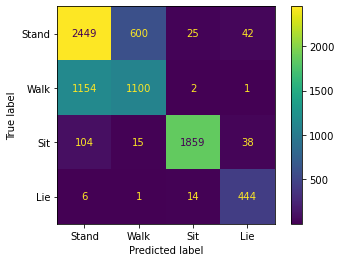

In [21]:
# Confusion Matrix
cm = metrics.confusion_matrix(y_test, uy_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp = disp.plot()

plt.savefig('confusion_matricies/c4_f113_km' + str(NUMBER_OF_CLUSTERS) + '+sw24_12+rae.png') # number of classes, features, method
plt.show()